In [261]:
import tensorflow as tf
import os
from scipy.io.wavfile import read
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
%matplotlib notebook

In [229]:
os.listdir('/input')

['1-ElectricCity.wav',
 'recovered.wav',
 '5-Breakdance.wav',
 '9-RockYourBody.wav',
 '14-RockYourBodyBrainbugRemix.wav',
 '6-GetFreaky.wav',
 '13-PackJam.wav',
 'before.wav',
 '10-DontStopTheRock.wav',
 '11-FunkyNation.wav',
 '16-MusicInstructorMegaMix.wav',
 '8-TechnicalLover.wav',
 'spectrogram2.png',
 '3-LetTheMusicPlay.wav',
 '4-SuperSonic.wav',
 '2-PlanetEarth.wav',
 'spectrogram.png',
 '15-WeAreTheRobots.wav',
 '7-JamOnIt.wav',
 '12-GalaxyJam.wav']

In [230]:
rate, audioData = read('/input/1-ElectricCity.wav')

In [231]:
print("Rate:", rate)

lengthMinutes = audioData.shape[0] / rate //  60
lengthSeconds = (audioData.shape[0] / rate / 60 - lengthMinutes) * 60
lengthStr = '{}:{}'.format(int(lengthMinutes), int(lengthSeconds))
print("Length:", lengthStr)
print("Data type:", audioData.dtype)

Rate: 44100
Length: 4:53
Data type: int16


In [232]:
channel1 = audioData[:,0] # left channel
channel2 = audioData[:,1] # right channel

### Constants and global variables

In [233]:
FFT_LENGTH = 1024
WINDOW_LENGTH = 512
WINDOW_STEP = int(WINDOW_LENGTH / 2)
magnitudeMin = float("inf")
magnitudeMax = float("-inf")
phaseMin = -math.pi
phaseMax = math.pi

In [234]:
with tf.Session() as sess:
    hello = tf.constant('Hello, Tensorflow!')
    print(sess.run(hello))
    

b'Hello, Tensorflow!'


Higher frequencies are less visible on spectrogram so we need to amplify it logarithmically.
We also need a fucntion to reverse this process while extracting wav back from spectrogram

In [253]:
def log10(x):
  numerator = tf.log(x)
  denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

def amplifyMagnitudeByLog(d):
    return 188.301 * math.log10(d + 1)

def weakenAmplifiedMagnitude(d):
    return math.pow(10, d/188.301)-1

## Generate spectrogram for wave
Get fragment of the song

<IPython.core.display.Javascript object>


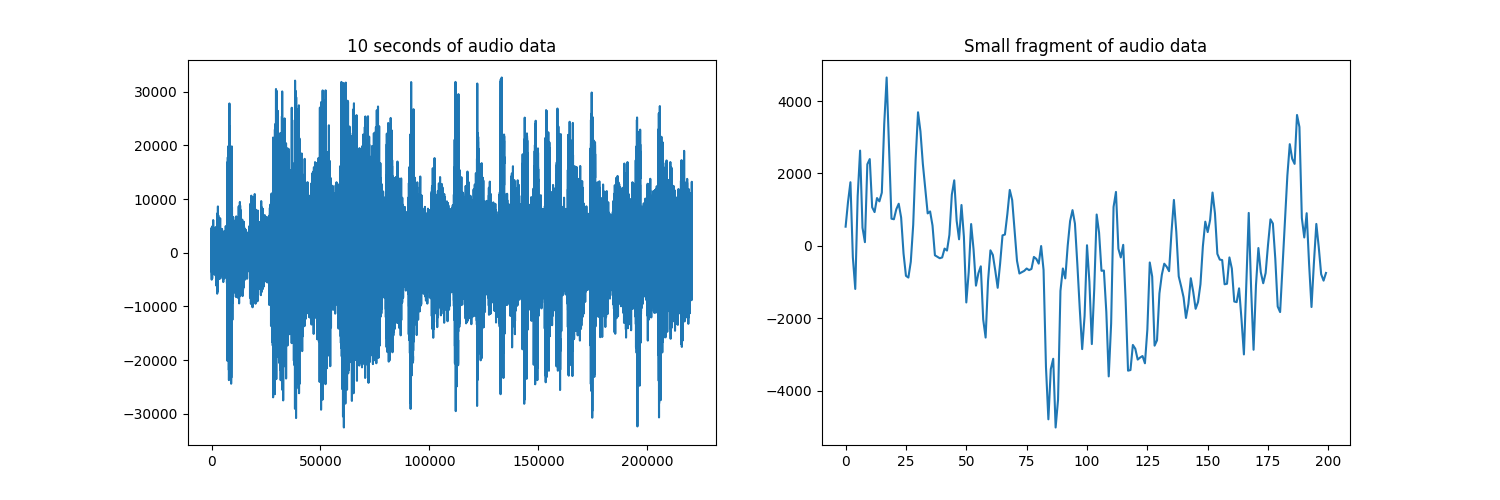

In [236]:
#take 10 seconds from 0:30 to 0:40
signal_fragment = channel1[30*rate:35*rate]
#plot the signal
plt.figure(1, figsize=(15, 5))
plt.subplot(121)
plt.plot(signal_fragment)
plt.title('10 seconds of audio data')
plt.subplot(122)
plt.plot(signal_fragment[:200])
plt.title('Small fragment of audio data')
plt.show()

In [269]:
def generateSpectrogramForWave(signal):
    with tf.Session() as sess:
        start_time = time.time()
        signals = tf.placeholder(tf.float32, [None])
        stft = tf.contrib.signal.stft(signals, 
                                    frame_length=WINDOW_LENGTH, 
                                    frame_step=WINDOW_STEP,
                                    fft_length=FFT_LENGTH,
                                    pad_end=True)
        #log_offset = 1e-6
        #mags = tf.transpose(tf.log(tf.abs(stft) + log_offset))
        mags = tf.transpose(tf.abs(stft))
        phases = tf.transpose(tf.angle(stft))
        m_max = tf.math.reduce_max(mags)
        m_min = tf.math.reduce_min(mags)
        # convert to pix
        mags = (mags - m_min) / (m_max - m_min) * 510
        mags = log10(mags + 1) * 188.301
        mags = tf.to_int32(mags)
        mags = tf.reverse(mags,[0])
        
        phases = (phases + math.pi) / (2*math.pi) * 255
        phases = tf.cast(phases, tf.uint8)
        phases = tf.reverse(phases,[0])
        
        red = tf.cast(tf.clip_by_value(mags, 0, 255), tf.uint8)
        green = tf.cast(tf.clip_by_value(mags - 255, 0, 255), tf.uint8)
        rgb = tf.stack([red, green, phases], axis=2)
        rgbArray, mags = sess.run([rgb, mags], feed_dict={signals: signal})
        elapsed_time = time.time() - start_time
        print('%.2f' % elapsed_time, 's', sep='')
    img = Image.fromarray(rgbArray, 'RGB')
    img.save("/input/spectrogram.png","PNG")

In [273]:


tf.reset_default_graph()
generateSpectrogramForWave(signal_fragment)




0.11s
